<a href="https://colab.research.google.com/github/lgpatruyo/Heart-Condition-Classification/blob/main/LSTM_2L_2FC_Rebal_3Classes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Modules

In [ ]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout, LSTM
from keras.layers import Input
from keras.models import Model
from keras.layers.normalization import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.np_utils import to_categorical

In [ ]:
# Modules
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Importing metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

import plotly.express as px
import matplotlib.pyplot as plt
%matplotlib inline


# Collecting MIT Dataset

In [ ]:
# IMPORTING MIT TRAINING DATA FROM MY DRIVE
df_MIT_Train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/mitbih_train.csv', header=None)

In [ ]:
df_MIT_Train[187].value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

In [ ]:
df_MIT_Train_VE = df_MIT_Train[df_MIT_Train[187]==2].reset_index().drop(['index'], axis=1)
df_MIT_Train_VE.index

RangeIndex(start=0, stop=5788, step=1)

In [ ]:
df_MIT_Train_VE.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.000000,0.009756,0.074390,0.162195,0.240244,0.291463,0.370732,0.442683,0.498780,0.560976,0.612195,0.612195,0.606098,0.614634,0.615854,0.631707,0.641463,0.632927,0.648780,0.667073,0.691463,0.682927,0.712195,0.730488,0.735366,0.731707,0.741463,0.732927,0.724390,0.690244,0.663415,0.653659,0.600000,0.569512,0.553659,0.530488,0.518293,0.503659,0.486585,0.496341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,1.000000,0.865672,0.660448,0.458955,0.242537,0.126866,0.164179,0.242537,0.298507,0.350746,0.373134,0.440298,0.447761,0.444030,0.425373,0.410448,0.414179,0.399254,0.406716,0.406716,0.395522,0.388060,0.399254,0.414179,0.425373,0.425373,0.451493,0.496269,0.537313,0.544776,0.611940,0.664179,0.701493,0.727612,0.750000,0.761194,0.746269,0.712687,0.697761,0.690298,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
2,0.556728,0.530343,0.440633,0.290237,0.171504,0.055409,0.005277,0.042216,0.000000,0.013193,0.044855,0.126649,0.213720,0.242744,0.253298,0.313984,0.361478,0.393140,0.456464,0.569921,0.604222,0.606860,0.612137,0.635884,0.641161,0.630607,0.656992,0.675462,0.678100,0.683377,0.688654,0.709763,0.725594,0.741425,0.762533,0.778364,0.786280,0.738786,0.717678,0.746702,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,1.000000,0.968031,0.782609,0.512788,0.418159,0.381074,0.347826,0.320972,0.312020,0.295396,0.291560,0.281330,0.271100,0.268542,0.260870,0.248082,0.235294,0.227621,0.216113,0.202046,0.182864,0.159847,0.144501,0.125320,0.103581,0.083120,0.060102,0.044757,0.033248,0.016624,0.006394,0.003836,0.000000,0.008951,0.015345,0.034527,0.048593,0.066496,0.094629,0.122762,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,0.000000,0.037681,0.101449,0.215942,0.236232,0.349275,0.389855,0.485507,0.539130,0.601449,0.611594,0.652174,0.686957,0.707246,0.711594,0.747826,0.786957,0.784058,0.814493,0.853623,0.866667,0.871014,0.907246,0.943478,0.924638,1.000000,0.946377,0.979710,0.875362,0.886957,0.810145,0.782609,0.728985,0.697101,0.666667,0.637681,0.639130,0.647826,0.582609,0.636232,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


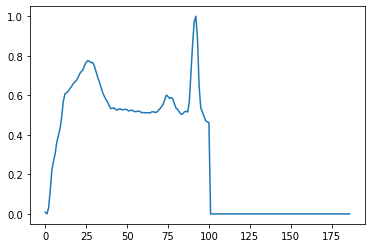

In [ ]:
#MIT ECG
plt.plot(df_MIT_Train_VE.iloc[100,:187])

In [ ]:
df_MIT_Train_VE.shape

(5788, 188)

# Collecting PTB Dataset

In [ ]:
# IMPORTING DATA WITH NO HEART CONDITION (NORMAL) FROM MY DRIVE
df_normal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_normal.csv', header=None)

In [ ]:
# IMPORTING DATA WITH HEART CONDITION (ABNORMAL) FROM MY DRIVE
df_abnormal = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final_Project/Data/ptbdb_abnormal.csv', header=None)

In [ ]:
df_abnormal.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,0.649870,0.635100,0.655083,0.664639,0.633362,0.746308,0.871416,0.938314,1.000000,0.948740,0.396177,0.000000,0.039096,0.128584,0.305821,0.640313,0.617724,0.537793,0.352737,0.220678,0.256299,0.357950,0.482189,0.570808,0.577758,0.620330,0.622068,0.618593,0.626412,0.612511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,0.125101,0.129136,0.137207,0.137207,0.132365,0.126715,0.158192,0.152542,0.132365,0.168684,0.156578,0.183212,0.191283,0.204197,0.230024,0.244552,0.285714,0.307506,0.321227,0.327684,0.351897,0.373688,0.397094,0.363196,0.340597,0.307506,0.258273,0.197740,0.199354,0.173527,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
df = pd.concat([df_normal, df_abnormal], axis=0, ignore_index=True)

In [ ]:
X_data = df.loc[:,:186]
y_data = df.loc[:,187]

In [ ]:
X_data.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186
0,1.0,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,0.106564,0.106969,0.115883,0.122366,0.122366,0.11953,0.115883,0.122366,0.126013,0.133712,0.134927,0.142626,0.151135,0.158428,0.163695,0.173825,0.188817,0.207861,0.230956,0.258509,0.294571,0.325770,0.362642,0.398298,0.429498,0.449352,0.450972,0.418963,0.372771,0.310373,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,0.361781,0.362400,0.366110,0.367965,0.374150,0.37786,0.382189,0.384663,0.398887,0.401361,0.418058,0.443414,0.457638,0.487941,0.520717,0.559678,0.604205,0.634508,0.653680,0.672851,0.678417,0.660482,0.621521,0.555968,0.482375,0.438466,0.378479,0.351268,0.319728,0.306741,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Preliminary ECG Visuals (PTB Dataset)

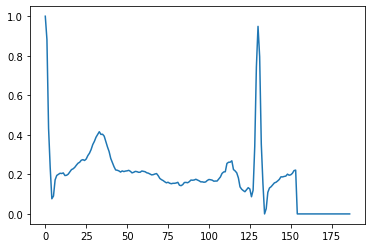

In [ ]:
#Normal ECG
plt.plot(X_data.loc[100,:])

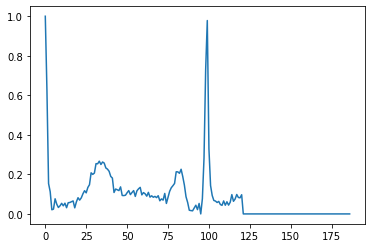

In [ ]:
#Abnormal ECG
plt.plot(X_data.loc[6000,:])

In [ ]:
y_data.value_counts()

1.0    10506
0.0     4046
Name: 187, dtype: int64

# Concat MIT VE CLASS TO PTB DATASET

In [ ]:
df_new = pd.concat([df, df_MIT_Train_VE], axis=0, ignore_index=True)

In [ ]:
df_new.isnull().sum().any()

False

In [ ]:
X_data_new = df_new.iloc[:,:187]
y_data_new = df_new.iloc[:,187]

# Splitting Data & Setting "y" Categorical

In [ ]:
dfX_train, dfX_test, y_train, y_test = train_test_split(X_data_new, y_data_new, shuffle=True, train_size=0.8, random_state = 42)

In [ ]:
y_train.value_counts()

1.0    8384
2.0    4625
0.0    3263
Name: 187, dtype: int64

In [ ]:
#Preparing the train dataset including "y" before balancing the classes.
df_train = pd.concat([dfX_train, pd.Series(y_train)], axis=1)

In [ ]:
df_train[187].value_counts()

1.0    8384
2.0    4625
0.0    3263
Name: 187, dtype: int64

In [ ]:
y_test.value_counts()

1.0    2122
2.0    1163
0.0     783
Name: 187, dtype: int64

# Balancing Classes in Train Set

In [ ]:
from sklearn.utils import resample

df_0=(df_train[df_train[187]==0])
df_2=(df_train[df_train[187]==2])
df_1=(df_train[df_train[187]==1]).sample(n=8300,random_state=42)

#resampling minority classes with replacement
df_0_upsample=resample(df_0,replace=True,n_samples=8300,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=8300,random_state=123)

#balanced df
df_train_balanced=pd.concat([df_0_upsample,df_1, df_2_upsample])

#shuffling rows in balanced df
df_train_shuffled=df_train_balanced.sample(frac=1).reset_index(drop=True)

In [ ]:
df_train_shuffled[187].value_counts()

2.0    8300
1.0    8300
0.0    8300
Name: 187, dtype: int64

In [ ]:
X_train_proc = df_train_shuffled.iloc[:,:187]
y_train_proc = df_train_shuffled.iloc[:,187]

In [ ]:
X_train_proc.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186
0,0.97884,0.742947,0.185345,0.007053,0.049373,0.127351,0.114028,0.110110,0.110110,0.105799,0.101881,0.098354,0.099138,0.102273,0.102665,0.104232,0.099138,0.104232,0.104624,0.105799,0.110893,0.119906,0.130878,0.139107,0.150862,0.161834,0.175940,0.199451,0.225313,0.252743,0.281740,0.313088,0.348354,0.382837,0.408699,0.429467,0.422022,0.382445,0.326411,0.259013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.00000,0.476835,0.211689,0.000000,0.007840,0.210976,0.265146,0.279401,0.314326,0.335709,0.343550,0.351390,0.358517,0.358517,0.358517,0.369209,0.374198,0.388453,0.396294,0.415538,0.424091,0.451889,0.479686,0.501782,0.559515,0.597292,0.641483,0.675695,0.684961,0.692088,0.685674,0.647185,0.589451,0.513186,0.439059,0.382751,0.339986,0.317177,0.308624,0.289380,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Formatting Train and Test

In [ ]:
#X_train_proc comes from rebalancing classes in train_set above
X_train = X_train_proc.iloc[:,:186].values

#dfx_test comes from splitting train/test section
X_test = dfX_test.iloc[:,:186].values

#for i in range(len(X_train)):
#    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])

# Changing the shape of X_train and X_test to3D arrays

X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)


In [ ]:
X_train.shape

(24900, 186, 1)

In [ ]:
y_train_cat=to_categorical(y_train_proc)
y_test_cat=to_categorical(y_test)

In [ ]:
# classes are ordered by index value 
y_train_cat[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.]], dtype=float32)

# LSTM NN

# Network Definition







In [ ]:
#reference for understanding LSTM return sequence parameter
#https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/

def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_lstm=Input(shape=(im_shape), name='inputs_lstm')
    lstm_1=LSTM(units=64, return_sequences=True, input_shape=im_shape)(inputs_lstm)
    #conv1_1=BatchNormalization()(conv1_1)
    #pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    lstm_2=LSTM(units=64, return_sequences=True)(lstm_1)
    #conv2_1=BatchNormalization()(conv2_1)
    #pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    #conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    #conv3_1=BatchNormalization()(conv3_1)
    #pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(lstm_2)
    #dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(flatten)
    main_output = Dense(3, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train, epochs=40,callbacks=callbacks, batch_size=32,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [ ]:
model,history=network(X_train,y_train_cat,X_test,y_test_cat)

Epoch 1/40
779/779 [==============================] - 46s 17ms/step - loss: 0.5467 - accuracy: 0.7653 - val_loss: 0.2823 - val_accuracy: 0.8837
Epoch 2/40
779/779 [==============================] - 12s 15ms/step - loss: 0.2219 - accuracy: 0.9117 - val_loss: 0.2060 - val_accuracy: 0.9179
Epoch 3/40
779/779 [==============================] - 11s 15ms/step - loss: 0.1404 - accuracy: 0.9476 - val_loss: 0.1330 - val_accuracy: 0.9594
Epoch 4/40
779/779 [==============================] - 12s 15ms/step - loss: 0.0996 - accuracy: 0.9633 - val_loss: 0.1748 - val_accuracy: 0.9457
Epoch 5/40
779/779 [==============================] - 12s 15ms/step - loss: 0.0908 - accuracy: 0.9668 - val_loss: 0.1254 - val_accuracy: 0.9612
Epoch 6/40
779/779 [==============================] - 12s 15ms/step - loss: 0.0615 - accuracy: 0.9769 - val_loss: 0.1035 - val_accuracy: 0.9705
Epoch 7/40
779/779 [==============================] - 12s 15ms/step - loss: 0.0542 - accuracy: 0.9805 - val_loss: 0.1265 - val_accuracy:

# Model Evaluation

In [ ]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    #Luis: Changed from strings to integer
    target_names=[0, 1]
    
    #y_true=[]
    #for element in y_test:
    #    y_true.append(np.argmax(element))
    #prediction_proba=model.predict(X_test)
    #prediction=np.argmax(prediction_proba,axis=1)
    #cnf_matrix = confusion_matrix(y_true, prediction)
    

Accuracy: 98.80%


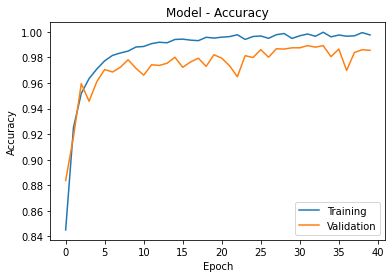

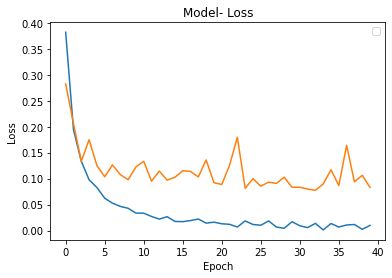

In [ ]:
evaluate_model(history,X_test,y_test_cat,model)

In [ ]:
y_pred=model.predict(X_test)
y_pred

array([[5.9507026e-21, 9.9802619e-01, 1.9738099e-03],
       [9.9999964e-01, 3.7676168e-07, 3.0381685e-12],
       [1.0000000e+00, 2.0144185e-08, 4.2527023e-17],
       ...,
       [7.5935213e-20, 1.0000000e+00, 4.2160882e-11],
       [6.6612651e-05, 9.9993336e-01, 1.6261012e-11],
       [4.1334835e-23, 1.0000000e+00, 6.6895919e-11]], dtype=float32)

In [ ]:
y_test_cat

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
y_check = y_test_cat.argmax(axis=1)
np.count_nonzero(y_check == 1)

2122

In [ ]:
#
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


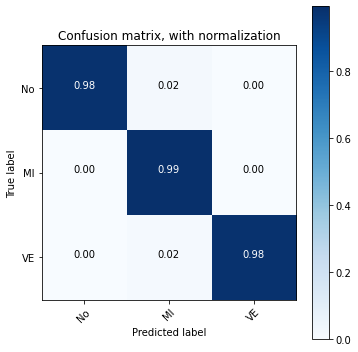

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['No', 'MI', 'VE'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
target_names = ['No', 'MI', 'VE']
print(classification_report(y_test_cat.argmax(axis=1), y_pred.argmax(axis=1),target_names=target_names))

              precision    recall  f1-score   support

          No       0.99      0.98      0.99       783
          MI       0.99      0.99      0.99      2122
          VE       0.99      0.98      0.99      1163

    accuracy                           0.99      4068
   macro avg       0.99      0.99      0.99      4068
weighted avg       0.99      0.99      0.99      4068

